In [1]:
import pandas as pd
import datetime
import stock_data as stock
import numpy as np
from tqdm import tqdm

### Get Data

import stock_data as stock

scrapy = stock.Scrapy()
today = datetime.datetime.today()
end = f"{today.year}-12-31"

price = scrapy.get_price(
    start = "2013-01-01",
    end = end,
    mode = "listed"
)
price.to_csv("data/price_2013_2023.csv", index = False)
print(f"length = {len(price)}")
price.head()

twiis = scrapy.get_price(
    start = "2013-01-01",
    end = end,
    mode = "other",
    query = "^TWII"
)
twiis.to_csv("data/twii_2013_2023.csv", index = False)

ratio = scrapy.get_financial_statement(
    type_ = 3,
    clean = 1, 
    mode = "listed",
    start_year = today.year-1911-10, 
    end_year = today.year-1911-1
)
ratio.to_csv("data/ratio_2013_2022.csv", index = False)
print(f"length = {len(ratio)}")
ratio.head()

income = scrapy.get_financial_statement(
    type_ = 1,
    clean = 1, 
    mode = "listed",
    start_year = today.year-1911-10, 
    end_year = today.year-1911-1
)
income.to_csv("data/income_2013_2022.csv", index = False)
print(f"length = {len(income)}")
income.head()

asset = scrapy.get_financial_statement(
    type_ = 2,
    clean = 1, 
    mode = "listed",
    start_year = today.year-1911-10, 
    end_year = today.year-1911-1
)
asset.to_csv("data/asset_2013_2022.csv", index = False)
print(f"length = {len(asset)}")
asset.head()

### Load Data

In [2]:
twii_raw = pd.read_csv("data/twii_2013_2023.csv", parse_dates = ["Date"])
price_raw = pd.read_csv("data/price_2013_2023.csv", parse_dates = ["Date"])
ratio_raw = pd.read_csv("data/ratio_2013_2022.csv")
income_raw = pd.read_csv("data/income_2013_2022.csv")
asset_raw = pd.read_csv("data/asset_2013_2022.csv")
print(f"twii_raw length = {len(twii_raw)}")
print(f"price length = {len(price_raw)}")
print(f"ratio length = {len(ratio_raw)}")
print(f"income_raw length = {len(income_raw)}")
print(f"asset_raw length = {len(asset_raw)}")

twii_raw length = 2617
price length = 2388161
ratio length = 35151
income_raw length = 36353
asset_raw length = 36353


price_raw = price_raw.query("(Date >= '2016-01-01')").sort_values("Date").reset_index(drop = True)
price_raw["Year"] = price_raw["Date"].dt.year

df_price = pd.DataFrame()
g_year = price_raw.groupby("Year")
for group_year, df_group_year in g_year:
    g_symbol = df_group_year.groupby("Symbol")
    for group_symbol, df_group_symbol in g_symbol:
        first = df_group_year.groupby("Symbol").first().reset_index()
        last = df_group_year.groupby("Symbol").last().reset_index()
        df_group = pd.concat([first, last])
    df_price = pd.concat([df_price, df_group], ignore_index = True)

df_price = df_price.sort_values(["Symbol", "Date"]).reset_index(drop = True)
df_price

#### Clean

In [3]:
def price(df):
    df = df.drop(["Open", "High", "Low", "Close"], axis = 1)
    df = df.rename(columns = {"Adj Close": "Close"})
    df["Year"] = df["Date"].dt.year
    return df

In [4]:
twii_raw = price(twii_raw)
twii_raw.head(3)

,Symbol,Date,Close,Volume,Year
0,^TWII,2013-01-02,7779.19,2194600,2013
1,^TWII,2013-01-03,7836.81,2964400,2013
2,^TWII,2013-01-04,7805.96,2696800,2013


In [5]:
price_raw["Symbol"] = price_raw["Symbol"].str.split(".").str[0]
price_raw = price_raw.sort_values(["Date", "Symbol"]).reset_index(drop = True)
price_raw = price(price_raw)
price_raw.head(3)

,Symbol,Date,Close,Volume,Year
0,1101,2013-01-02,16.79,8646455.0,2013
1,1102,2013-01-02,20.13,2955776.0,2013
2,1103,2013-01-02,9.09,319260.0,2013


In [6]:
def statement(df, keep_col, new_col_name):
    df = df.iloc[:, keep_col]
    df.columns = new_col_name
    df = df.sort_values(["Year", "Season", "Symbol"]).reset_index(drop = True)
    df["Symbol"] = df["Symbol"].astype(str)
    df["Year"] = df["Year"] + 1911

    return df

In [7]:
ratio_raw = statement(ratio_raw, keep_col = [0,1,2,3,4,5,6,8], new_col_name = ['Year', 'Season', 'Symbol', 'Name', "Sales", "Gross", "Operating", "Net"])
ratio_raw.head(3)

,Year,Season,Symbol,Name,Sales,Gross,Operating,Net
0,2013,1,1101,台泥,24114.05,12.95,8.40,8.29
1,2013,1,1102,亞泥,13931.55,6.40,2.44,9.84
2,2013,1,1103,嘉泥,741.19,-6.06,-20.21,8.05


In [8]:
income_raw = statement(income_raw, keep_col = [0,1,2,3,4,5,6,8,10], new_col_name = ['Year', 'Season', 'Symbol', 'Name', "Sales", "Gross", "Operating", "Net", "EPS"])
income_raw.head(3)

,Year,Season,Symbol,Name,Sales,Gross,Operating,Net,EPS
0,2013,1,1101,台泥,24114047.0,3123872.0,2026729.0,1999624.0,0.38
1,2013,1,1102,亞泥,13931550.0,892180.0,339801.0,1371559.0,0.40
2,2013,1,1103,嘉泥,741189.0,-44905.0,-149811.0,59637.0,0.13


In [9]:
asset_raw = statement(asset_raw, keep_col = [0,1,2,3,6,14], new_col_name = ['Year', 'Season', 'Symbol', 'Name', "Asset", "Equity"])
asset_raw.head(3)

,Year,Season,Symbol,Name,Asset,Equity
0,2013,1,1101,台泥,272835233.0,145365698.0
1,2013,1,1102,亞泥,205656837.0,104251999.0
2,2013,1,1103,嘉泥,28976954.0,16395990.0


### Imputer time

In [10]:
def imputer_time(df, name):
    df1 = pd.DataFrame()
    g = df.groupby("Symbol")
    for group, df_group in tqdm(g, desc = name):
        combinations = df[["Year", "Season"]].value_counts().index
        combinations = combinations.sort_values().to_frame(index = False)
        df_group = pd.merge(combinations, df_group, on = ["Year", "Season"], how = "left")
        df1 = pd.concat([df1, df_group], ignore_index = True)
    df1[["Symbol", "Name"]] = df1[["Symbol", "Name"]].fillna(method = "ffill")    
    df1 = df1.sort_values(["Year", "Season", "Symbol"]).reset_index(drop = True)

    return df1

In [11]:
ratio_raw  = imputer_time(df = ratio_raw,  name = "ratio")
income_raw = imputer_time(df = income_raw, name = "income")
asset_raw  = imputer_time(df = asset_raw,  name = "asset")

print(f"ratio length = {len(ratio_raw)}")
print(f"income_raw length = {len(income_raw)}")
print(f"asset_raw length = {len(asset_raw)}")

ratio:   2%|▏         | 17/957 [00:00<00:11, 83.03it/s]

asset: 100%|██████████| 983/983 [00:10<00:00, 92.79it/s] 


ratio length = 38280
income_raw length = 39320
asset_raw length = 39320


### Remove cumulative

In [12]:
def remove_cumulative(df, name, col):
    g1 = df.groupby("Symbol")
    df_symbol = pd.DataFrame()
    for group1, df_group1 in tqdm(g1, desc = name):
        g2 = df_group1.groupby("Year")
        df_year = pd.DataFrame()
        
        for group2, df_group2 in g2:
            df_group2 = df_group2.reset_index(drop = True)
            df_group2_1 = df_group2[col] - df_group2[col].shift(1)
            df_group2_1.loc[0] = df_group2.loc[0, col]
            df_group2[col] = df_group2_1
            df_year = pd.concat([df_year, df_group2], ignore_index = True)

        df_symbol = pd.concat([df_symbol, df_year], ignore_index = True)

    df_symbol = df_symbol.sort_values(["Year", "Season", "Symbol"]).reset_index(drop = True)
    
    return df_symbol

In [13]:
# ratio_raw  = remove_cumulative(df = ratio_raw,  name = "ratio",  col = ['Sales'])
income_raw1 = remove_cumulative(df = income_raw, name = "income", col = ['Sales', 'Gross', 'Operating', 'Net', 'EPS'])

income:   0%|          | 0/983 [00:00<?, ?it/s]

income: 100%|██████████| 983/983 [00:57<00:00, 17.07it/s]


### Split year

In [14]:
def split_year(df, name):
    dfs = {}
    g = df.groupby("Year")
    for group, df_group in tqdm(g, desc = name):
        df_group = df_group.reset_index(drop = True)
        dfs[group] = df_group
    
    return dfs

In [15]:
prices  = split_year(df = price_raw,   name = "price")
twiis   = split_year(df = twii_raw,    name = "twii")
ratios  = split_year(df = ratio_raw,   name = "ratio")
incomes = split_year(df = income_raw1, name = "income")
assets  = split_year(df = asset_raw,   name = "asset")

price:   0%|          | 0/11 [00:00<?, ?it/s]

asset: 100%|██████████| 10/10 [00:00<00:00, 908.88it/s]


### Filter stock by ratio

In [16]:
filter_stock = []
for year in tqdm(range(2015, 2023), desc = "year"):
    # 合併近三年財務比率
    ratio = pd.concat([ratios[year-2], ratios[year-1], ratios[year]])

    # Q4要隔年3月才會公布，只抓到Q3
    ratio = ratio.set_index(["Year", "Season"])
    ratio = ratio.loc[(year-2, 4) : (year, 3)].reset_index()
    # print(f"ratio length = {len(ratio)}")

    # 營收YOY為正，且三率三升
    ratio1 = pd.DataFrame()
    g = ratio.groupby("Symbol")
    for group, df_group in g:
        df_group = df_group.reset_index(drop = True)
        
        # 近8季 營收、毛利率、營業利益率、稅後淨利率 > 0
        remove_flag = (df_group.loc[:, "Sales":"Net"] < 0).any().any()
        if remove_flag:
            continue
        
        # 近四季 營收YOY > 0
        df_group["Sales_pct"] = df_group["Sales"].pct_change(4).values
        remove_flag = (df_group["Sales_pct"] < 0).any()
        if remove_flag:
            continue
        
        # 近四季 三率三升
        keep_flag = (df_group.loc[:3, "Sales":"Net"] < df_group.shift(-4).loc[:3, "Sales":"Net"]).all().all()
        if (keep_flag) and (len(df_group) >= 4):
            df_group = df_group.iloc[-4:].reset_index(drop = True)
            ratio1 = pd.concat([ratio1, df_group], ignore_index = True)
    ratio = ratio1.copy()

    portfolio = ratio["Symbol"].unique()

    filter_stock.append([year+1, len(portfolio), portfolio])


filter_stock = pd.DataFrame(filter_stock, columns = ["Year", "Port_Count", "Portfolio"])
filter_stock

year: 100%|██████████| 8/8 [00:18<00:00,  2.35s/it]


,Year,Port_Count,Portfolio
0,2016,25,"[1108, 1227, 1460, 1477, 1536, 1539, 1702, 170..."
1,2017,23,"[1319, 1460, 1568, 1752, 2228, 2345, 2355, 240..."
2,2018,16,"[1215, 1463, 1909, 2233, 2421, 2428, 2912, 300..."
3,2019,25,"[1102, 1109, 1256, 1301, 1436, 1457, 1597, 160..."
4,2020,20,"[1102, 1470, 1477, 1514, 2458, 2904, 3034, 341..."
5,2021,16,"[1210, 1541, 1732, 1786, 2107, 2313, 2383, 244..."
6,2022,54,"[1513, 1720, 2010, 2032, 2108, 2247, 2303, 235..."
7,2023,51,"[1475, 1477, 1524, 1560, 1708, 1712, 2034, 204..."


### Filter stock by income and asset

In [17]:
filter_stock1 = []
for i in tqdm(range(len(filter_stock)), desc = "year"):
    year = filter_stock.loc[i, "Year"] - 1
    income = pd.concat([incomes[year-2], incomes[year-1], incomes[year]]) # 合併近三年財報
    portfolio = filter_stock.loc[i, "Portfolio"]
    income = income.query("Symbol in @portfolio").reset_index(drop = True)

    # Q4要隔年3月才會公布，只抓到Q3
    income = income.set_index(["Year", "Season"])
    income = income.loc[(year-2, 4) : (year, 3)].reset_index()

    # YOY皆為正
    income1 = pd.DataFrame()
    g = income.groupby("Symbol")
    for group, df_group in g:
        df_group = df_group.reset_index(drop = True)

        # 近8季 所有值 > 0
        remove_flag = (df_group.loc[:, "Sales":"EPS"] < 0).any().any()
        if remove_flag:
            continue

        # 所有值 近四季 比 近八到五季 高
        keep_flag = (df_group.loc[:3, "Sales":"EPS"] < df_group.shift(-4).loc[:3, "Sales":"EPS"]).all().all()
        if (keep_flag) and (len(df_group) >= 4):
            df_group = df_group.iloc[-4:].reset_index(drop = True)
            income1 = pd.concat([income1, df_group], ignore_index = True)

    income = income1.copy()
    portfolio = income["Symbol"].unique()
    filter_stock1.append([year+1, len(portfolio), portfolio])

filter_stock = pd.DataFrame(filter_stock1, columns = ["Year", "Port_Count", "Portfolio"])
filter_stock

year: 100%|██████████| 8/8 [00:00<00:00, 10.02it/s]


,Year,Port_Count,Portfolio
0,2016,12,"[1477, 1536, 1708, 2231, 2317, 2383, 2464, 411..."
1,2017,7,"[1319, 2345, 2488, 2492, 4755, 6239, 9938]"
2,2018,10,"[1215, 1463, 1909, 2912, 3003, 3005, 4551, 523..."
3,2019,14,"[1102, 1109, 1597, 2049, 2327, 2344, 2458, 249..."
4,2020,11,"[1102, 1470, 1477, 2458, 3034, 3416, 4119, 413..."
5,2021,6,"[2383, 2454, 3042, 6257, 6464, 8081]"
6,2022,31,"[1513, 2010, 2108, 2303, 2353, 2357, 2376, 237..."
7,2023,25,"[1477, 1560, 1708, 1712, 2059, 2303, 2368, 260..."


In [18]:
filter_stock1 = []
for i in tqdm(range(len(filter_stock)), desc = "year"):
    year = filter_stock.loc[i, "Year"] - 1
    portfolio = filter_stock.loc[i, "Portfolio"]
    
    # 今年
    q4 = income_raw.query("(Symbol in @portfolio) & (Year == @year-1) & (Season == 4)").reset_index(drop = True) # 去年Q4
    income = income_raw.query("(Symbol in @portfolio) & (Year == @year) & (Season == 3)").reset_index(drop = True)
    income.loc[:, "Sales":"EPS"] += q4.loc[:, "Sales":"EPS"]
    # 去年
    q4_last = income_raw.query("(Symbol in @portfolio) & (Year == @year-2) & (Season == 4)").reset_index(drop = True) # 去年Q4
    income_last = income_raw.query("(Symbol in @portfolio) & (Year == @year-1) & (Season == 3)").reset_index(drop = True)
    income_last.loc[:, "Sales":"EPS"] += q4_last.loc[:, "Sales":"EPS"]
    income = pd.concat([income_last, income], ignore_index = True)
    
    asset = assets[year].query("Season == 3") # 今年
    asset_last = assets[year-1].query("Season == 3") # 去年
    asset = pd.concat([asset_last, asset], ignore_index = True)
    
    asset = pd.merge(asset, income, on = ["Year", "Season", "Symbol", "Name"])

    # 計算淨利率、資產周轉率、權益乘數、ROE
    asset["Net_ratio"] = asset["Net"] / asset["Sales"]
    asset["asset_turnover_ratio"] = asset["Sales"] / asset["Asset"]
    asset["Equity_Multiplier"] = asset["Asset"] / asset["Equity"]
    asset["ROE"] = asset["Net"] / asset["Equity"]

    # 今年淨利率、資產周轉率、ROE > 去年淨利率、資產周轉率、ROE
    up_index = ["Net_ratio", "asset_turnover_ratio", "ROE"]
    keep_up_index = (asset.query("(Year == @year)")[up_index].values) >= (asset.query("(Year == @year-1)")[up_index].values)
    keep_up_index = keep_up_index.all(axis = 1)

    # 今年權益乘數 < 去年權益乘數
    keep_down_index = (asset.query("(Year == @year)")["Equity_Multiplier"].values) <= (asset.query("(Year == @year-1)")["Equity_Multiplier"].values)
    keep_index = keep_up_index & keep_down_index
    
    asset = asset.query("(Year == @year)")[keep_index].reset_index(drop = True)

    if len(asset) != 0:
        portfolio = asset["Symbol"].unique()
        filter_stock1.append([year+1, len(portfolio), portfolio])

filter_stock = pd.DataFrame(filter_stock1, columns = ["Year", "Port_Count", "Portfolio"])
filter_stock

year: 100%|██████████| 8/8 [00:00<00:00, 17.24it/s]


,Year,Port_Count,Portfolio
0,2016,4,"[1708, 2317, 2383, 4119]"
1,2017,4,"[1319, 2345, 4755, 9938]"
2,2018,2,"[1463, 5234]"
3,2019,4,"[1109, 2049, 2327, 4958]"
4,2020,4,"[1102, 2458, 3034, 4119]"
5,2021,1,[2454]
6,2022,9,"[1513, 2303, 2376, 2377, 3042, 3257, 3711, 455..."
7,2023,12,"[1560, 1708, 2303, 2603, 2606, 2607, 3653, 371..."


### Caculate return

In [19]:
portfolio_price = pd.DataFrame(columns = ["Year", "Symbol", "Start", "End", "Return"])
for i in range(len(filter_stock)):
    year = filter_stock.loc[i, "Year"]
    price = prices[year]
    portfolio = filter_stock.loc[i, "Portfolio"]

    # 抓出篩選出的股票
    price = price.query("(Symbol in @portfolio)")
    price = price.sort_values(["Symbol", "Date"]).reset_index(drop = True)

    # 計算每檔股票的報酬率
    total_return = []
    price1 = pd.DataFrame()
    g = price.groupby("Symbol")
    groups = price["Symbol"].unique()
    for group in groups:
        df_group = g.get_group(group)
        start = df_group["Close"].iloc[0] # 年初
        end = df_group["Close"].iloc[-1] # 年底
        return_ = (end - start) / start * 100 # 報酬率
        total_return.append(return_)
        portfolio_price.loc[len(portfolio_price)] = [year, group, start, end, return_]

    if len(total_return) > 0:
        filter_stock.loc[i, "Port_Return"] = round(np.mean(total_return), 2)
    else:
        filter_stock.loc[i, "Port_Return"] = total_return

    # 加權指數
    twii = twiis[year]
    twii = twiis[year].sort_values(["Symbol", "Date"]).reset_index(drop = True)
    start = twii["Close"].iloc[0] # 年初
    end = twii["Close"].iloc[-1] # 年底
    return_twii = round((end - start) / start * 100, 2) # 報酬率
    filter_stock.loc[i, "TWII_Return"] = return_twii

filter_stock = filter_stock[['Year', 'Port_Return', 'TWII_Return', 'Port_Count', 'Portfolio']]

In [20]:
filter_stock

,Year,Port_Return,TWII_Return,Port_Count,Portfolio
0,2016,16.03,14.04,4,"[1708, 2317, 2383, 4119]"
1,2017,59.86,14.77,4,"[1319, 2345, 4755, 9938]"
2,2018,3.96,-9.18,2,"[1463, 5234]"
3,2019,62.10,25.57,4,"[1109, 2049, 2327, 4958]"
4,2020,25.50,21.75,4,"[1102, 2458, 3034, 4119]"
5,2021,56.30,22.26,1,[2454]
6,2022,-11.73,-22.62,9,"[1513, 2303, 2376, 2377, 3042, 3257, 3711, 455..."
7,2023,18.33,14.97,12,"[1560, 1708, 2303, 2603, 2606, 2607, 3653, 371..."


In [21]:
portfolio_price.query("Year == 2023")

,Year,Symbol,Start,End,Return
28,2023,1560,104.47,154.50,47.889346
29,2023,1708,37.52,31.10,-17.110874
30,2023,2303,38.60,45.20,17.098446
31,2023,2603,87.74,116.00,32.208799
32,2023,2606,44.64,47.85,7.190860
33,2023,2607,26.42,28.55,8.062074
34,2023,3653,369.11,623.00,68.784373
35,2023,3711,87.81,109.50,24.701059
36,2023,4919,112.18,125.00,11.428062
37,2023,6183,56.95,67.40,18.349429


writer = pd.ExcelWriter('data/output.xlsx', engine = 'xlsxwriter')
filter_stock.to_excel(writer, sheet_name = 'performance', index = False)
portfolio_price.to_excel(writer, sheet_name = 'portfolio_price', index = False)
writer.close()

In [22]:
total_return = pd.DataFrame()
for i in range(len(filter_stock)):
    year = filter_stock.loc[i, "Year"]
    price = prices[year]
    portfolio = filter_stock.loc[i, "Portfolio"]
    # print(f"price length = {len(price)}")

    # 抓出篩選出的股票
    price = price.query("(Symbol in @portfolio)")
    price = price.sort_values(["Symbol", "Date"]).reset_index(drop = True)

    
    start_price = price.groupby("Symbol").first()["Close"].to_dict()
    price["Start"] = price["Symbol"].map(start_price)
    price["Return"] = price.eval("(Close - Start) / Start * 100")
    df_return = price.groupby("Date").agg({"Return": "mean"}).round(2)
    total_return = pd.concat([total_return, df_return])

In [23]:
start_year = filter_stock.loc[0, "Year"]
start_date = price_raw.query("Year >= @start_year").groupby("Year").first()["Date"].values

In [24]:
twii = twii_raw.query("Year >= @start_year").reset_index(drop = True)
start_price = twii.groupby("Year").first()["Close"].to_dict()
twii["Start"] = twii["Year"].map(start_price)
twii["Return"] = twii.eval("(Close - Start) / Start * 100")
twii = twii.set_index("Date")["Return"]

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

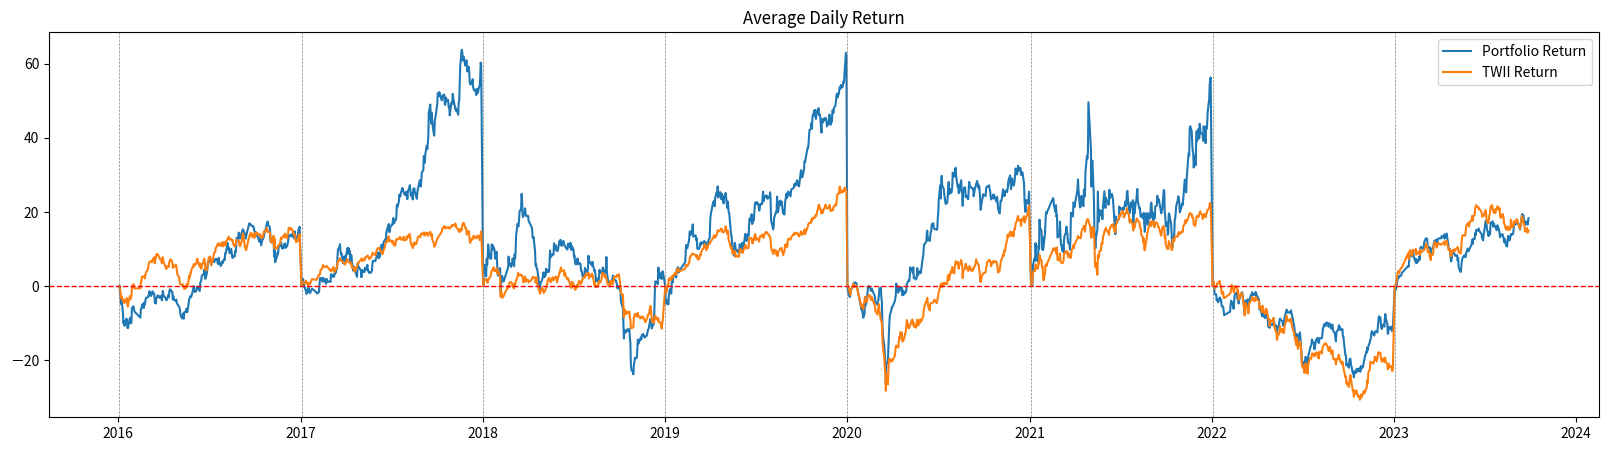

In [26]:
plt.figure(figsize=(20, 5))
plt.plot(total_return, label = 'Portfolio Return')
plt.plot(twii, label = 'TWII Return')
plt.axhline(y = 0, color = 'r', linestyle='--', linewidth = 1)
for date in start_date:
    plt.axvline(x = date, color = 'gray', linestyle='--', linewidth = 0.5)

plt.title("Average Daily Return")
plt.legend()
plt.show()